## Challenge Description
Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country. She therefore went and talked to the international team in charge of Spain And LatAm to see if they had any ideas about why that was happening.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish- speaking countries had the same translation of the site which was written by a Spaniard. They agreed to try a test where each country would have its one translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican and so on. Obviously, nothing would change for users from Spain.
After they run the test however, they are really surprised cause the test is negative. I.e., it appears that the non-localized translation was doing better!

### Project goal:
You are asked to:
1. Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
2. Explain why that might be happening. Are the localized translations really worse?
3. If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.


### Data
2 tables:

#### test_table: test results

Columns:

user_id : the id of the user. Unique by user. Can be joined to user id in the other table. For each user, we just check whether conversion happens the first time they land on the site since the test started.

date : when they came to the site for the first time since the test started

source : marketing channel: Ads, SEO, Direct . Direct means everything except for ads and SEO. Such as directly typing site URL on the browser, downloading the app w/o coming from SEO or Ads, referral friend, etc.

device : device used by the user. It can be mobile or web

browser_language : in browser or app settings, the language chosen by the user. It can be EN, ES, Other (Other means any language except for English and Spanish) 

ads_channel : if marketing channel is ads, this is the site where the ad was displayed. It can be: Google, Facebook, Bing, Yahoo ,Other. If the user didn't come via an ad, this field is NA

browser : user browser. It can be: IE, Chrome, Android_App, FireFox, Iphone_App, Safari, Opera

conversion : whether the user converted (1) or not (0). This is our label. A test is considered successful if it increases the proportion of users who convert.

test : users are randomly split into test (1) and control (0). Test users see the new translation and control the old one. For Spain-based users, this is obviously always 0 since there is no change there.

#### user_table: user info

Columns:

user_id : the id of the user. It can be joined to user id in the other table sex : user sex: Male or Female

age : user age (self-reported)

country : user country based on ip address

## Data exploration

In [181]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn import tree
import graphviz

In [141]:
test_data = pd.read_csv('test_table.csv')
user_data = pd.read_csv('user_table.csv')

In [142]:
test_data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [143]:
# Make sure the unique values are as expected
for col in ['source', 'device', 'browser_language', 'ads_channel', 
          'browser', 'conversion', 'test']:
    print (test_data[col].unique())

['Direct' 'Ads' 'SEO']
['Web' 'Mobile']
['ES' 'Other' 'EN']
[nan 'Google' 'Facebook' 'Bing' 'Yahoo' 'Other']
['IE' 'Chrome' 'Android_App' 'FireFox' 'Iphone_App' 'Safari' 'Opera']
[1 0]
[0 1]


In [144]:
test_data.describe(include=['object'])

,date,source,device,browser_language,ads_channel,browser
count,453321,453321,453321,453321,181877,453321
unique,5,3,2,3,5,7
top,2015-12-04,Ads,Web,ES,Facebook,Android_App
freq,141163,181877,251565,377547,68425,155135


In [145]:
user_data.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [146]:
for col in ['sex', 'age', 'country']:
    print(user_data[col].unique())

['M' 'F']
[20 27 23 29 31 21 49 24 22 18 37 25 26 28 54 19 33 36 38 34 35 32 39 41
 42 48 30 40 47 45 43 46 44 51 61 52 57 50 56 63 55 53 58 70 60 59 65 62
 64 68 67 66]
['Mexico' 'Nicaragua' 'Colombia' 'Venezuela' 'Spain' 'Ecuador' 'Paraguay'
 'Bolivia' 'Argentina' 'Peru' 'Chile' 'Guatemala' 'Costa Rica' 'Honduras'
 'El Salvador' 'Panama' 'Uruguay']


In [147]:
user_data.describe(include=['object'])

,sex,country
count,452867,452867
unique,2,17
top,M,Mexico
freq,264485,128484


In [148]:
# Just focus on spanish browser
test_data = test_data[test_data['browser_language']=='ES']

In [149]:
# LEFT Merge test_data with user_data 
test_user_merge = pd.merge(test_data,user_data,how='left',on='user_id')
test_user_merge.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
4,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1,F,22.0,Venezuela


In [150]:
1 - test_user_merge['country'].isna().sum()/len(test_user_merge['country'])

0.9989749620577041

Percentage of user_id have info about sex,age, country: 99.9%

In [151]:
# remove unmateched rows
test_user_merge = test_user_merge[-test_user_merge['country'].isna()]

Check whether Spain has the higest conversion rate. 

In [152]:
conversion_country = test_user_merge[['conversion', 'country']].groupby('country').mean().reset_index().sort_values(by='conversion',ascending=False)
conversion_country

,country,conversion
14,Spain,0.079799
10,Nicaragua,0.054294
4,Costa Rica,0.052307
3,Colombia,0.051951
6,El Salvador,0.051808
7,Guatemala,0.050595
9,Mexico,0.050455
16,Venezuela,0.050275
13,Peru,0.049929
11,Panama,0.049848


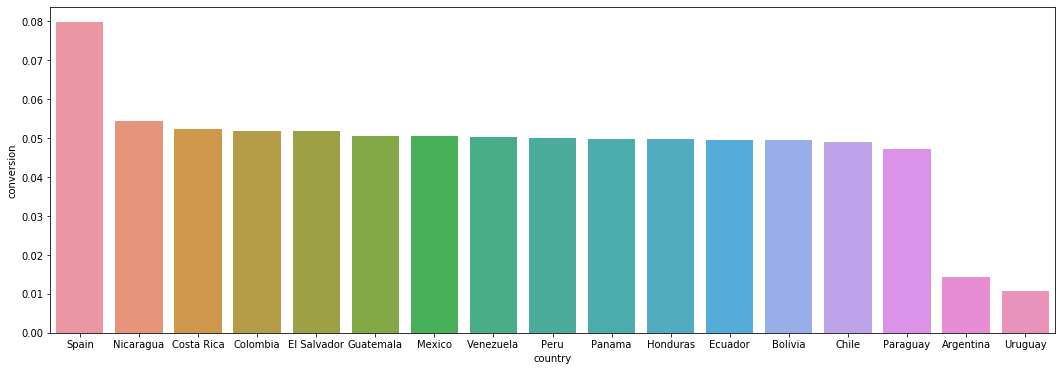

In [153]:
# Visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='country', y='conversion', data=conversion_country, ax=ax)
plt.show()

Checked: It is true Spain converts much better than the rest of LatAm countries.

## AB test analysis 

### Check whether test is worse than control group.

In [154]:
# remove spain
test_user_merge = test_user_merge[test_user_merge['country']!='Spain']

In [155]:
conversion_test = test_user_merge[['conversion', 'test']].groupby('test').mean().reset_index()
conversion_test

,test,conversion
0,0,0.048622
1,1,0.043519


In [156]:
1-conversion_test['conversion'][1]/conversion_test['conversion'][0]

0.10494218476672135

Okay, conversion rate of control group is 10.5% higher than test group.

However, whether the result makes significant different, we could use Welch Two Sample t-test.

Null hypothesis is that test is similar to control.

In [157]:
test_val = test_user_merge[test_user_merge['test'] == 1]['conversion'].values
cont_val = test_user_merge[test_user_merge['test'] == 0]['conversion'].values
print(ttest_ind(test_val, cont_val, equal_var=False))

Ttest_indResult(statistic=-6.99996606202615, pvalue=2.5652349687869257e-12)


P value is very small (<5%), so we reject the null hypothesis. So test group is indeed worse than control group. Which is, local translation is worse than spain translation.

### Find out way
The most likely reason for weird A/B test results are:

1. We did not collect enough data.
2. Some bias has been introduced in the experiment so that test/control people are not picked random enough.

Let us find out those bias! 
1. plot day by day, to see if these weird results have been constanly happening or they just started happening all of a sudden.
2. Segmentation like country, source, device, sex, ... the distribution of people in test and control for each segment should be approximately the same. 

#### Plot day by day:

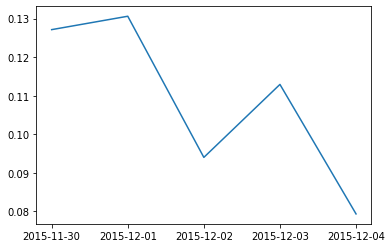

In [158]:
test_day = test_user_merge[test_user_merge['test'] == 1].groupby('date').mean().reset_index()[['date','conversion']]
control_day = test_user_merge[test_user_merge['test'] == 0].groupby('date').mean().reset_index()[['date','conversion']]
ratio = 1-test_day[['conversion']]/control_day[['conversion']]
ratio_day = pd.concat([test_day[['date']],ratio], axis=1)
plt.plot(ratio_day['date'],ratio_day['conversion'])
plt.show()

1. We can see that test has contantly been worse than control and there is relatively little variance across days. That probably means we do have enough data, but there was some bias in the experiment set up. 
2. On a side note, experiment has just ran it for 5 days. We should always run the test for at least 1 full week to capture weekly patterns, 2 weeks will be much better.

#### Segmentation for basis

Segmentation by country: 

In [159]:
# test rate per country
test_rate_country = test_user_merge[['test', 'country']].groupby('country').mean().reset_index().sort_values(by='test',ascending=False)
test_rate_country

,country,test
14,Uruguay,0.896931
0,Argentina,0.800164
12,Paraguay,0.506159
11,Panama,0.505167
1,Bolivia,0.502918
13,Peru,0.500357
9,Mexico,0.499935
4,Costa Rica,0.498401
3,Colombia,0.498283
2,Chile,0.497231


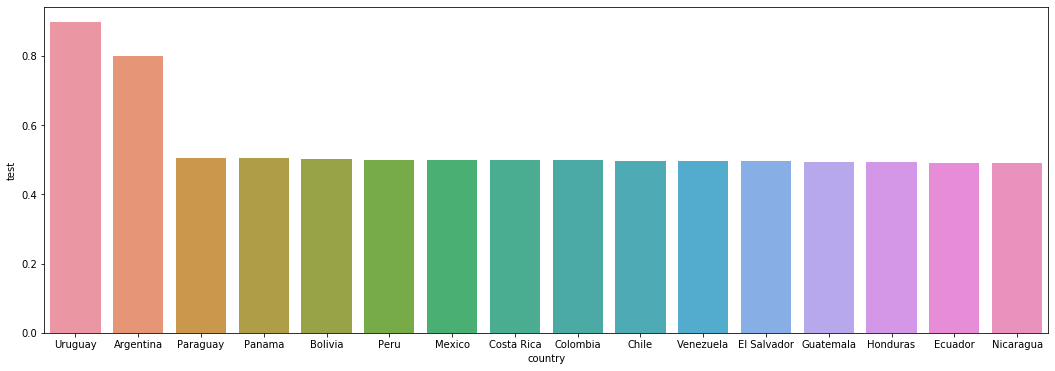

In [160]:
# Visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='country', y='test', data=test_rate_country, ax=ax)
plt.show()

The rest countries have approximately 50% test/control split apart from Argentina and Uruguay.

So let us check the test results after controlling for country. i.e. we check for each country how the test is doing.

Apply t test for each country.

In [162]:
countries = [name for name in test_user_merge['country'].unique()]

print('{0:15s} {1:>15s} {2:>15s} {3:>10s}'.format('Country', 'Test Rate', 'Control Rate', 'P-Value'))
print('-' * 65)
for country in countries:
    test_val = test_user_merge[(test_user_merge['country'] == country) & (test_user_merge['test'] == 1)]['conversion'].values
    cont_val = test_user_merge[(test_user_merge['country'] == country) & (test_user_merge['test'] == 0)]['conversion'].values
    
    test_mean = test_val.mean()
    cont_mean = cont_val.mean()
    p_val = ttest_ind(test_val, cont_val, equal_var=False).pvalue
    
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(country, test_mean, cont_mean, p_val))

Country               Test Rate    Control Rate    P-Value
-----------------------------------------------------------------
Mexico                  0.05094         0.04997   0.470370
Venezuela               0.04983         0.05071   0.741526
Bolivia                 0.04942         0.04957   0.974288
Colombia                0.05101         0.05288   0.371507
Uruguay                 0.01097         0.00843   0.624401
El Salvador             0.04888         0.05468   0.281661
Nicaragua               0.05457         0.05403   0.927973
Peru                    0.05046         0.04939   0.680626
Argentina               0.01407         0.01540   0.389765
Chile                   0.04969         0.04829   0.678838
Ecuador                 0.04880         0.05040   0.671890
Guatemala               0.05131         0.04990   0.718264
Honduras                0.04899         0.05061   0.754037
Paraguay                0.04705         0.04722   0.974192
Panama                  0.05174         0.04791  

After we control for country, the test clearly appears non significant. 

Not a great success given that the goal was to improve conversion rate, but at least we know that a localized translation did not make things worse (not better)

In [78]:
# test rate is normal for other subgroups:
test_user_merge[['test', 'sex']].groupby('sex').mean().reset_index()
test_user_merge[['test', 'date']].groupby('date').mean().reset_index()
test_user_merge[['test', 'source']].groupby('source').mean().reset_index()
test_user_merge[['test', 'device']].groupby('device').mean().reset_index()
test_user_merge[['test', 'ads_channel']].groupby('ads_channel').mean().reset_index()
test_user_merge[['test', 'browser']].groupby('browser').mean().reset_index()

,browser,test
0,Android_App,0.477825
1,Chrome,0.480239
2,FireFox,0.472954
3,IE,0.473237
4,Iphone_App,0.473452
5,Opera,0.473726
6,Safari,0.470817


## future check
How to check whether segment is bais in the future. One way is to build a decision tree where variables are the user dimensions and the outcome variable is whether the user is in test or control. 

If the tree splits, it means that for given values of that variable you are more likely to end up in test or control.

But this should be impossible. Therefore, if the randomization worked, the tree should not split at all (or at least not be able to separate the two classes well).

In [208]:
clf = tree.DecisionTreeClassifier(max_depth = 2)
data = test_user_merge[['country','sex','source','device','ads_channel','browser','test']]
data = pd.get_dummies(data,columns = ['country','sex', 'source','device','ads_channel','browser'])

In [209]:
clf = clf.fit(data.loc[:, data.columns != 'test']
, data['test'])

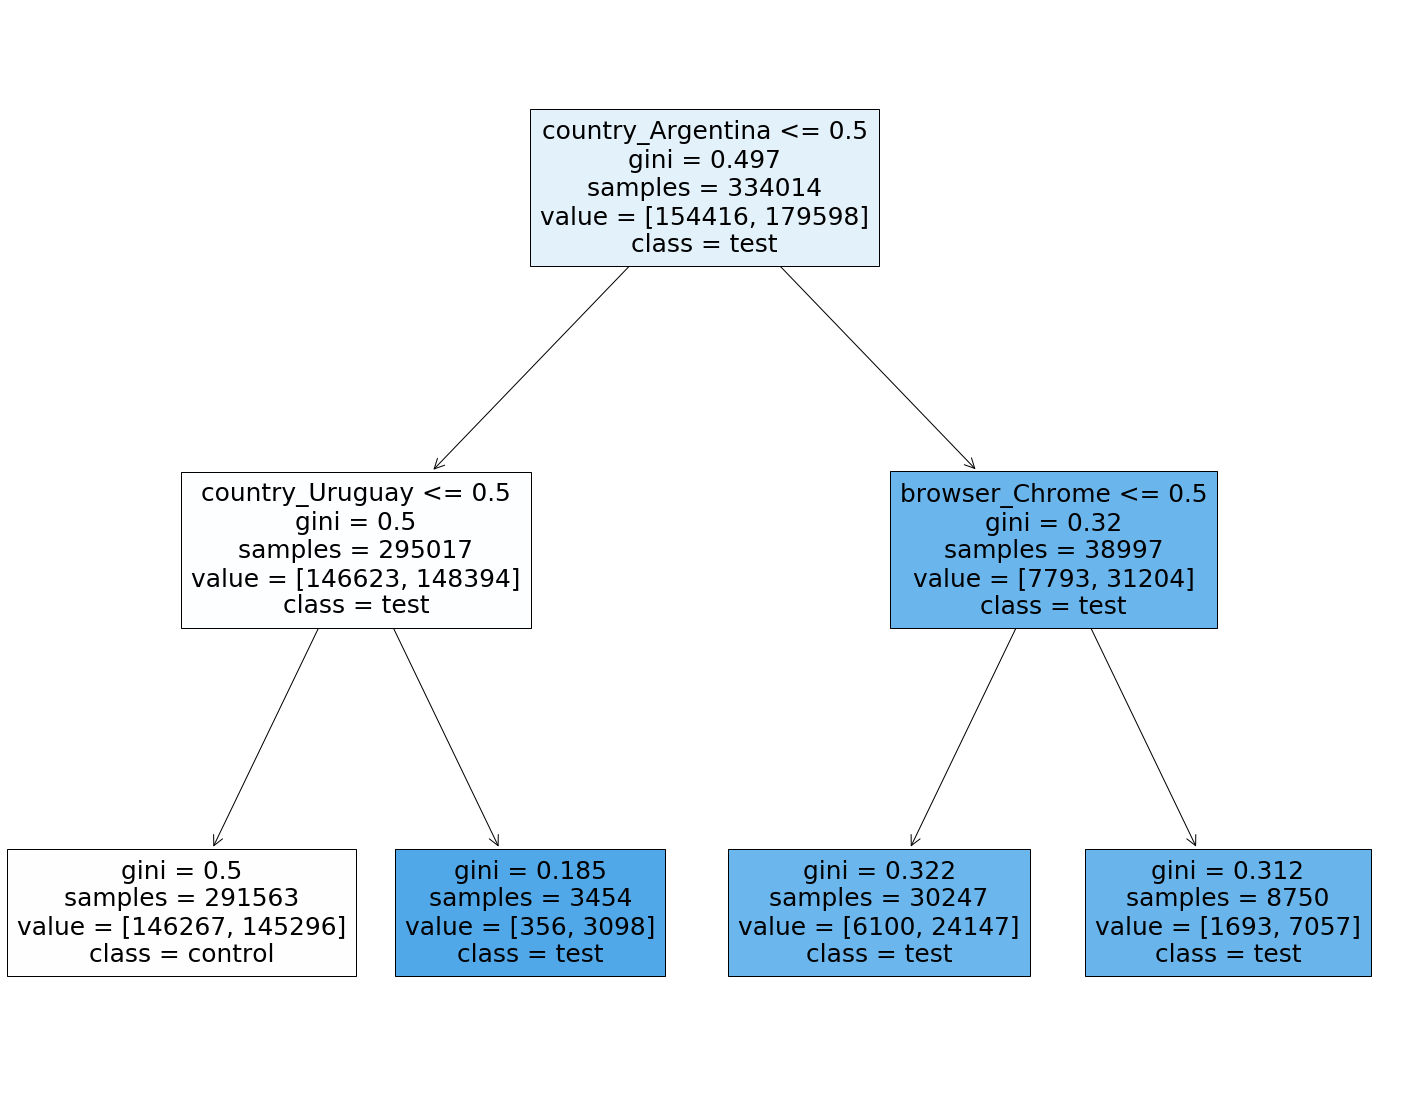

In [223]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=data.columns[1:],  
                   class_names=['control','test'],
                   filled=True)